### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization 
from bert import tokenization
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Concatenate, Reshape, Dropout, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
import tensorflow_addons as tfa
from tensorflow.keras import initializers



import warnings
warnings.filterwarnings("ignore")

### Loading Data After EDA

In [2]:
train = pd.read_csv('train_eda.csv')

train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [3]:
test = pd.read_csv('test_eda.csv')

test.head()

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45


In [4]:
y = train['target']

### Text Preprocessing

### Removing URL's 

In [5]:
def remove_URL(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    return text

In [6]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Removing HTML Tags

In [7]:
def remove_html(text):
    tags = re.compile('<.*?>') 
    text = re.sub(tags, '', text)
    return text

In [8]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

### Removing Emojis 

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return re.sub(emoji_pattern, '', text)

In [10]:
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

### Removing Punctuations 

In [11]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [12]:
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

### Removing Stopwords 

In [13]:
def remove_stop(text):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    return text

In [14]:
train['text'] = train['text'].apply(lambda x : remove_stop(x))
test['text'] = test['text'].apply(lambda x : remove_stop(x))

In [15]:
clean_train = train['text']
clean_test = test['text']

In [16]:
clean_train.to_csv('clean_train.csv', index = False)
clean_test.to_csv('clean_test.csv', index = False)

In [17]:
y.to_csv('target.csv', index = False)

### Wordcloud

In [14]:
def create_corpus_df(df, target):
    corpus = []
    
    for x in df[df['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#### Real Disaster 

In [16]:
corpus_new_1 = create_corpus_df(train, 1)
len(corpus_new_1)

34803

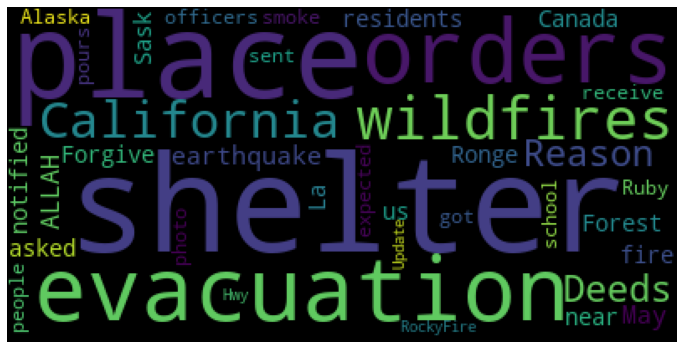

In [17]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_new_1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#### Not Disaster 

In [18]:
corpus_new_0 = create_corpus_df(train, 0)
len(corpus_new_0)

43013

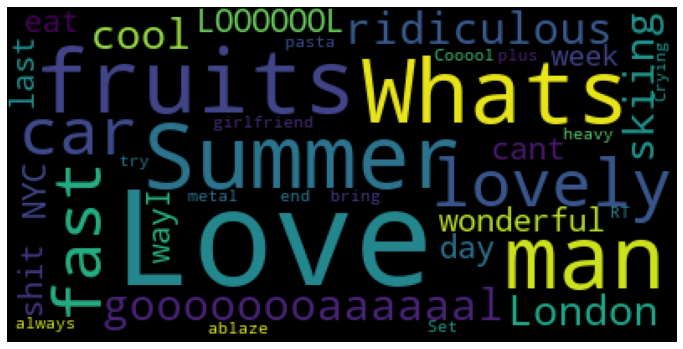

In [19]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_new_0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Bag of Words 

In [20]:
train_corpus = train['text']
test_corpus = test['text']

X_train, X_cv, y_train, y_cv = train_test_split(train_corpus, y, test_size = 0.2, random_state = 42)

In [21]:
vec = CountVectorizer()
vec.fit(X_train)

X_train_bow = vec.transform(X_train)
X_cv_bow = vec.transform(X_cv)

X_test_bow = vec.transform(test['text'])

In [38]:
print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)

(6090, 15453)
(1523, 15453)
(3263, 15453)


### TfIdf 

In [22]:
vec = TfidfVectorizer()
vec.fit(X_train)

X_train_tfidf = vec.transform(X_train)
X_cv_tfidf = vec.transform(X_cv)

X_test_tfidf = vec.transform(test['text'])

In [36]:
print(X_train_tfidf.shape)
print(X_cv_tfidf.shape)
print(X_test_tfidf.shape)

(6090, 15453)
(1523, 15453)
(3263, 15453)


### GloVe 

In [15]:
embeddings_dict = dict()

f = open('glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_dict[word] = coefs
f.close()

In [16]:
max_words = 100000
max_sequence_length = 50
embedding_dim = 100

In [21]:
tf.keras.backend.clear_session()

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

cv_sequences = tokenizer.texts_to_sequences(X_cv)
cv_padded = pad_sequences(cv_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, padding = 'post', truncating = 'post', maxlen = max_sequence_length)

In [22]:
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
embedding_matrix.shape

(15676, 100)

### BERT 

In [22]:
def bert_encode(texts, tokenizer, max_len = 512):
    
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [23]:
max_seq_length = 160

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = sequence_output[:, 0, :])

In [24]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [25]:
train_input = bert_encode(X_train, tokenizer, max_len = 160)
cv_input = bert_encode(X_cv, tokenizer, max_len = 160)
test_input = bert_encode(test['text'], tokenizer, max_len = 160)

In [31]:
train_bert = bert_model.predict([train_input])
cv_bert = bert_model.predict([cv_input])
test_bert = bert_model.predict([test_input])

102/102 [==============================] - 1379s 14s/step


In [25]:
train_bert = joblib.load('train_bert.pkl')
cv_bert = joblib.load('cv_bert.pkl')
test_bert = joblib.load('test_bert.pkl')

In [26]:
print(train_bert.shape)
print(cv_bert.shape)
print(test_bert.shape)

(6090, 768)
(1523, 768)
(3263, 768)


### Models 

### Logistic Regression + BOW 

In [46]:
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']

hyperparameters = dict(C=C, penalty=penalty, solver=solver)

lr = LogisticRegression()
gridsearch = GridSearchCV(lr, hyperparameters)
best_model = gridsearch.fit(X_train_bow, y_train)
print(best_model.best_estimator_)

LogisticRegression(penalty='l1', solver='saga')


In [67]:
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train_bow, y_train)

y_pred_train = lr.predict(X_train_bow)
y_pred_cv = lr.predict(X_cv_bow)

In [68]:
f1_score(y_train, y_pred_train)

0.8453566348303191

In [69]:
f1_score(y_cv, y_pred_cv)

0.7475409836065574

### Logistic Regression + TfIdf 

In [71]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']

hyperparameters = dict(C=C, penalty=penalty, solver=solver)

lr = LogisticRegression()
random = RandomizedSearchCV(lr, hyperparameters)
best_model = random.fit(X_train_tfidf, y_train)
print(best_model.best_estimator_)

LogisticRegression(C=10, penalty='l1', solver='saga')


In [83]:
lr = LogisticRegression(C=10, penalty='l1', solver='saga')
lr.fit(X_train_tfidf, y_train)

y_pred_train = lr.predict(X_train_tfidf)
y_pred_cv = lr.predict(X_cv_tfidf)

In [84]:
f1_score(y_train, y_pred_train)

0.986579754601227

In [85]:
f1_score(y_cv, y_pred_cv)

0.7213891081294396

### Logistic Regression + BOW + PCA

In [91]:
pca = PCA()
pca.fit(X_train_bow.todense())

train_bow_pca = pca.transform(X_train_bow.todense())
cv_bow_pca = pca.transform(X_cv_bow.todense())
test_bow_pca = pca.transform(X_test_bow.todense())

PCA()

Text(0, 0.5, 'cumulative explained variance')

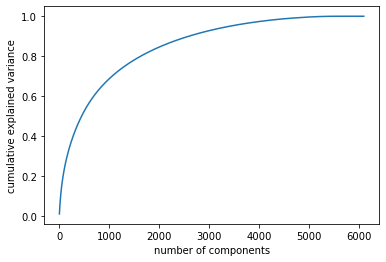

In [94]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [100]:
train_bow_pca = train_bow_pca[:, :4000]
cv_bow_pca = cv_bow_pca[:, :4000]
test_bow_pca = test_bow_pca[:, :4000]

In [107]:
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(train_bow_pca, y_train)

y_pred_train = lr.predict(train_bow_pca)
y_pred_cv = lr.predict(cv_bow_pca)

In [108]:
f1_score(y_train, y_pred_train)

0.8734381297863765

In [109]:
f1_score(y_cv, y_pred_cv)

0.7473426001635323

### Random Forest + BOW 

In [111]:
n_estimators = [10, 25, 50, 100, 200, 300, 400, 500]
max_features = ['auto', 'sqrt']
max_depth = [3, 5, 10, 15, 20, 25, 30]
min_samples_split = [2, 3, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

parameters = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

rfc = RandomForestClassifier()
classifier = RandomizedSearchCV(rfc, param_distributions = parameters, verbose = 10, n_jobs = -1)
best_classifier = classifier.fit(X_train_bow, y_train)
best_param = best_classifier.best_estimator_.get_params()
print(best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [112]:
rfc = RandomForestClassifier(n_estimators = 300, max_features = 'auto', max_depth = 30, min_samples_split = 15, min_samples_leaf = 5)
rfc.fit(X_train_bow, y_train)

y_pred_train = rfc.predict(X_train_bow)
y_pred_cv = rfc.predict(X_cv_bow)

In [113]:
f1_score(y_train, y_pred_train)

0.5360310421286031

In [114]:
f1_score(y_cv, y_pred_cv)

0.5107832009080591

### LSTM + GloVe 

In [27]:
input_layer = Input(shape = (50, ))
embedding = Embedding(input_dim = vocab_size, output_dim = embedding_dim, weights = [embedding_matrix], input_length = 50)(input_layer)
lstm = LSTM(32, return_sequences = True, recurrent_dropout = 0.5)(embedding)
flatten = Flatten()(lstm)
dense_1 = Dense(300, activation = "relu", kernel_initializer = "he_normal")(flatten)
dropout = Dropout(0.5)(dense_1)
dense_2 = Dense(200, activation="relu", kernel_initializer = "glorot_normal")(dropout)
normalization = BatchNormalization()(dense_2)
dropout_1 = Dropout(0.5)(normalization)
dense_3 = Dense(80, activation = "relu", kernel_initializer= "glorot_normal" )(dropout_1)
output = Dense(2, activation = 'softmax')(dense_3)

model = Model(inputs = input_layer, outputs = output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           1567600   
                                                                 
 lstm (LSTM)                 (None, 50, 32)            17024     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 300)               480300    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               60200 

In [28]:
checkpoint = ModelCheckpoint("lstm_model.h5", monitor="val_f1_score", mode="max", save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_f1_score', mode="max", min_delta = 0, patience = 1)

%load_ext tensorboard
!rm -rf ./logs/ 
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

callbacks = [checkpoint, earlystop, tensorboard]

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
y_train_ = to_categorical(y_train)
y_cv_ = to_categorical(y_cv)

In [30]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = [tfa.metrics.F1Score(num_classes =  2, average = 'micro')])

In [31]:
history = model.fit(train_padded, y_train_, epochs=10, verbose=1,callbacks = callbacks, validation_data = (cv_padded, y_cv_))

Epoch 1/10
191/191 [==============================] - 44s 165ms/step - loss: 0.5596 - f1_score: 0.7406 - val_loss: 0.4710 - val_f1_score: 0.8083
Epoch 2/10
191/191 [==============================] - 22s 113ms/step - loss: 0.4274 - f1_score: 0.8213 - val_loss: 0.4533 - val_f1_score: 0.8148
Epoch 3/10
191/191 [==============================] - 19s 98ms/step - loss: 0.3459 - f1_score: 0.8594 - val_loss: 0.4456 - val_f1_score: 0.8030


### Neural Network + BERT 

In [71]:
input_layer = Input(shape = (train_bert.shape[1], ))

layer1 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(input_layer)
layer2 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer1)
layer3 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer2)
layer4 = Dense(50, activation = 'relu', kernel_initializer = initializers.HeUniform(seed = 0))(layer3)

output = Dense(2, activation = 'softmax', kernel_initializer = initializers.RandomUniform(0, 1, seed = 0))(layer4)

model = Model(inputs = input_layer, outputs = output)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_26 (Dense)            (None, 50)                38450     
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            (None, 50)                2550      
                                                                 
 dense_29 (Dense)            (None, 50)                2550      
                                                                 
 dense_30 (Dense)            (None, 2)                 102       
                                                                 
Total params: 46,202
Trainable params: 46,202
Non-trainable

In [72]:
checkpoint = ModelCheckpoint("bert_model.h5", monitor="val_f1_score", mode="max", save_best_only = True)
callbacks = [checkpoint, earlystop, tensorboard]

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [tfa.metrics.F1Score(num_classes =  2, average = 'micro')])


In [73]:
history = model.fit(train_bert, y_train_, epochs = 10, validation_data = (cv_bert, y_cv_), callbacks = callbacks, verbose = 1)

Epoch 1/10
191/191 [==============================] - 11s 49ms/step - loss: 0.7221 - f1_score: 0.6923 - val_loss: 0.5471 - val_f1_score: 0.7905
Epoch 2/10
191/191 [==============================] - 2s 8ms/step - loss: 0.5018 - f1_score: 0.7936 - val_loss: 0.4894 - val_f1_score: 0.7833


### Tabulating Results 

In [9]:
from prettytable import PrettyTable
myTable = PrettyTable(["Model", "Train", "Validation"])

myTable.add_row(['Logistic Regression + BOW', '0.85', '0.75'])
myTable.add_row(['Logistic Regression + TfIdf', '0.98', '0.72'])
myTable.add_row(['Logistic Regression + BOW + PCA', '0.87', '0.74'])
myTable.add_row(['Random Forest + BOW', '0.53', '0.51'])
myTable.add_row(['LSTM + GloVe', '0.83', '0.81'])
myTable.add_row(['BERT', '0.79', '0.78'])

In [10]:
print(myTable)

+---------------------------------+-------+------------+
|              Model              | Train | Validation |
+---------------------------------+-------+------------+
|    Logistic Regression + BOW    |  0.85 |    0.75    |
|   Logistic Regression + TfIdf   |  0.98 |    0.72    |
| Logistic Regression + BOW + PCA |  0.87 |    0.74    |
|       Random Forest + BOW       |  0.53 |    0.51    |
|           LSTM + GloVe          |  0.83 |    0.81    |
|               BERT              |  0.79 |    0.78    |
+---------------------------------+-------+------------+
